# **Segment Landscape based on S2 composites**

Authors: 
- Victor Tang

Reviewed/Edited by:
- Marcos Kavlin
- Dr. Andrew Dean

### Purpose

This notebook is the second in the Wetland Function Assessment Tutorial.
The goal of this notebook is to show you, the user, how to segment your area of interest into homogenous landscape units of analysis based on S2 composites.


### Workflow

1. Import required packages.
2. Load multi-date S2 imagery.
3. Apply the Scharr Edge detection algorithm.
4. Visualize the resulting edge detection layer.
5. Extract landscape units for analysis.
6. Save out Landscape units of interest.

### Notes

The composites that were used to run this notebook are placeholders used to demonstrate this workflow. The data required to run the steps demonstrated in this notebook are cloud-free S2 composites. In this example we use four S2 composites that were created during dry periods between 2020, and 2021. The composites only contained the 'Red', 'Green' 'Blue', and 'Near Infrared' bands, as they have 10m resolution natively. The four separate composites were used for this process, as stacking images from multiple dates can effectivley highlight landscape boundaries (Xu et al., 2023).

**Segmentation reference:**

Sentinel-2 based image segmentation is developed based on the methodology proposed by [Xu et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0034425722004801). 

## 1. Import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import geopandas as gpd
import contextily as ctx

import xarray as xr
import rioxarray as rxr

from skimage.filters import scharr

import random
import jenkspy

from scipy import ndimage as ndi

from skimage import morphology
from skimage.segmentation import watershed
from shapely.geometry import shape
from rasterio.features import shapes

## 2. Load Multi-Date Sentinel-2 Images

In this step all four dry season composites are opened using the rioxarray package, anda appended to an empty list.
This rasters in this list are then stacked as different bands within an xarray.DataArray.

In [ ]:
base_dir = '/geoanalytics_user_shared_data/vtang/PEOPLE-ER_Vietnam/'

fpath_list = [
    base_dir  + 'sentinel-2/pc_4b_p30/an_giang_s2_2020_jfm.tif',
    base_dir  + 'sentinel-2/pc_4b_p30/an_giang_s2_2020_amj.tif',
    base_dir  + 'sentinel-2/pc_4b_p30/an_giang_s2_2021_jfm.tif',
    base_dir  + 'sentinel-2/pc_4b_p30/an_giang_s2_2021_amj.tif',
]

da_list = []
for fpath in tqdm(fpath_list):
    da_list.append(rxr.open_rasterio(fpath))

da = xr.concat(da_list, dim='band')

## 3. Apply the Scharr Edge Detection algorithm

Once we've concatenated the Sentinel 2 composites, we can now apply the Scharr Edge Detection algorithm to the resulting xarray.DataArray in order to obtain an edge layer.

For for information on the skimage function used for Scharr edge detection in this notebook follow this link: https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharrhttps://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharr

In [ ]:
nb = da.shape[0]

edges_list = []
for i in tqdm(range(nb)):
    img = da[i, :, :]
    edges_list.append(scharr(img))

edges = np.stack(edges_list, axis=0)
edges = np.nanmean(edges, axis=0)

## 4. Visualize the Edge Layer

The next step is to check our Edge layer in order to visually validate it.

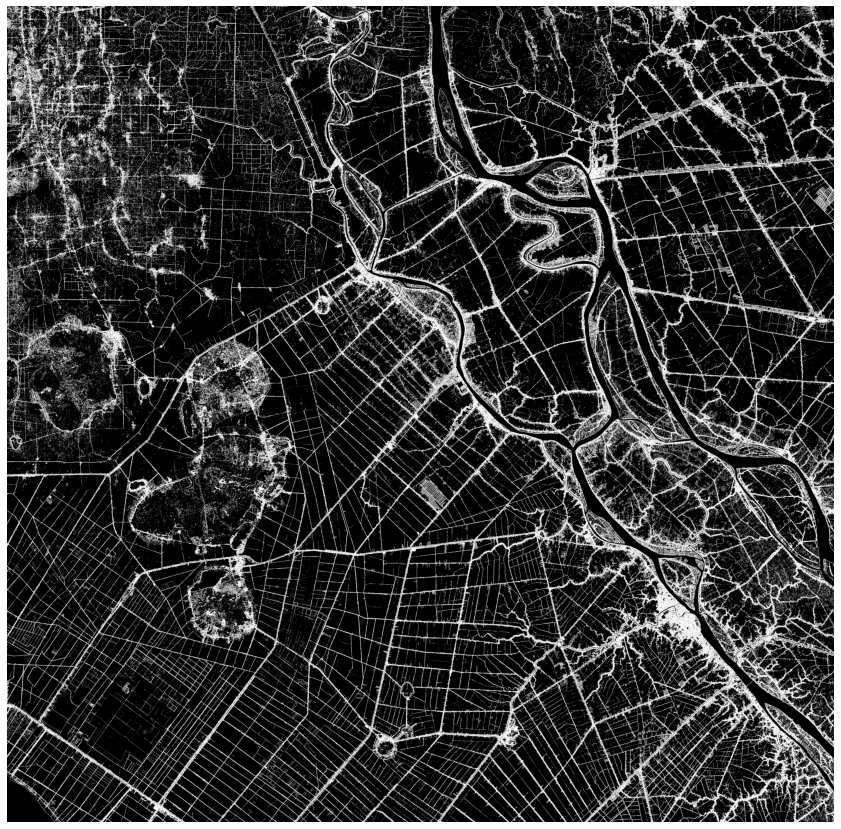

In [4]:
thr = 200
edges_c = np.digitize(edges, [thr])

fig, ax = plt.subplots(figsize=[15, 15])
ax.imshow(edges_c, cmap='gray')
ax.set_axis_off()

## 5. Extract Landscape Units of Analysis

Once we are happy with our results we can then focus on extracting the landscape units we'll use to analyze our area of interest.
To do so we will use a combination of morphological operations (i.e. erosion, dilation, opening, and closing) to remove the black and white noise in Edge image.
The processing done in the cell below to the edge layer will improve the integrity of the segmentation (avoiding over-segmentation issues).

The steps in the following cell build on one another in order to do so.

***Please note that the parameters set here are specific to the example study area. We highly recommend you spend some time playing around with the parameters of the functions used to optimize your results. If you would like to read about the functions please find the documentation for skimage morpholy linked: https://scikit-image.org/docs/stable/api/skimage.morphology.html***

In [5]:
edges_1 = morphology.binary_closing(edges_c, morphology.square(9))
edges_2 = morphology.binary_opening(edges_1, morphology.square(3))
edges_3 = morphology.area_opening(edges_2, area_threshold=64, connectivity=2)
edges_4 = morphology.area_closing(edges_3, area_threshold=256, connectivity=2)

### 5.1 Watershed Segmentation

Now that we've reduced the noise in edges, we can focus on actually segmenting our landscape. 

Watershed segmentation requires two inputs: 

- A greyscale image (edge layer) 
- Markers (which we'll create in the next cell)

> The grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. The algorithm starts filling isolated valleys (local minima) with different colored 'water' (labels). As the 'water' rises, depending on the peaks (gradients) nearby, 'water' from different valleys, with different colors will start to merge. To avoid that, this algorithm build barriers in the locations where 'water' merges. It continue the work of filling 'water' and building barriers until all the peaks are under water. Then the barriers are returned as the segmentation result. </br> </br>
> The marker-based watershed algorithm was developed to avoid oversegmentation caused by image noise or irregularities. The input marker layer specifies which valley points should be merged and which should remain separate. Regions of foreground and background should be labelled as 1 or 0 respectively.

More information and examples can be found in https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

In [6]:
markers = 1 - edges_4
markers = morphology.binary_erosion(markers, morphology.square(7))

markers, nf = ndi.label(markers)

Once we've created our markers using binary erosion, we can now use the watershed function from skimage.segmentation, to finally segment the watershed.

In [7]:
x = edges.flatten()
x = x[~np.isnan(x)]
x = random.choices(x, k=100000)
brks = jenkspy.jenks_breaks(x, 11)

# reclassify
edges_rc = np.digitize(edges, brks)

# process the watershed
segm = watershed(edges_rc, markers)

### 5.2 Convert Segmentation to Polygons

The next step is to take our binary segmented raster file, and convert it to vector format.
The first step is to define a function to help us do so.

In [ ]:
def convert_raster_to_polygons(da: np.ndarray) -> list:
    """This function converts a raster to a list of polygons

    Args:
        da: np.ndarray
            Binary raster which we wish
            to convert to a list of polygons.

    Returns:
        plys: list
            A list of polygons extracted
            from the binary input raster.

    """
    plys = shapes(
        da.values.astype(np.int16),
        mask=da.values > 0,
        transform=da.rio.transform(),
    )
    plys = [shape(item[0]) for item in list(plys)]
    return plys


We can then use our newly defined function to convert our raster to polygons, and append them all into a GeoPandas geodataframe.
It's important to make sure we're setting the crs from our edge detection raster to our geodataframe.

In [8]:
da2 = da.isel(band=0).copy()
da2.data = segm
geom_list = convert_raster_to_polygons(da2)
gdf = gpd.GeoDataFrame(geometry=geom_list)
gdf.crs = da2.rio.crs
gdf.shape

(7799, 1)

### 5.3 Visualize Final Polygons

Finally, as a final visual check, we plot our geodataframe, with a high-resolution basemap in order to see our results. 

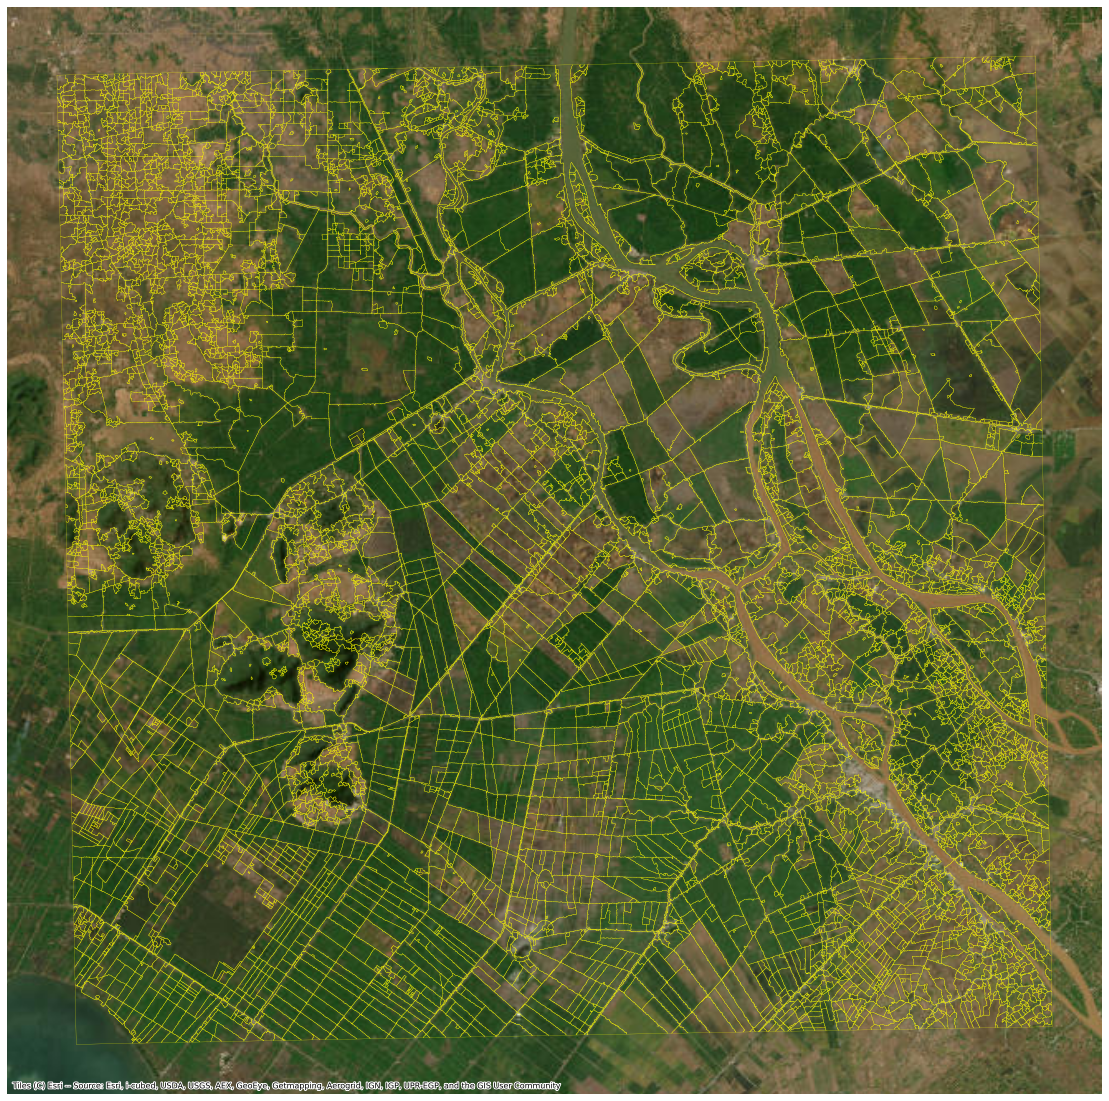

In [9]:
ax = gdf.to_crs('epsg:3857').boundary.plot(color='yellow', lw=.2, figsize=[20, 20])
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
ax.set_axis_off()

## 6. Export Landscape Units

Finally, we might want to export our landscape polygons to use in the steps of our analysis. 
To do so we can use the following line of code.

In [10]:
gdf.to_file(f'{output_path}/an_giang_segmentation.geojson')